In [2]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import glob

WRF visulisation using python
=====

Loading WRF data 
---

Importing the modules and shortcuts we'll need for visulisation. Link for more details on iris can be found at https://scitools-iris.readthedocs.io/en/stable/

In [6]:
input_file = "wrfout_d02_2011-04-01_00:00:00"
input_loc = "~/WISER_training/CONFER_WRF_hydro_python/example_data"
output_loc = "~/WISER_training/plots"

Setting file locations as global variables at start. Any  more global config variables you add go here. **Add your own wrfout file to test here!**

In [7]:
cubes = iris.load(f"{input_loc}/{input_file}")

/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'C1H' invalid units 'Dimensionless'
  warnings.warn(msg)
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'NEE' invalid units 'g/m2/s CO2'
  warnings.warn(msg)
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'CROPCAT' invalid units 'category'
  warnings.warn(msg)
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'C1F' invalid units 'Dimensionless'
  warnings.warn(msg)
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: User

We will get several warnings while loading in the input data as the units field is not CF-compliant. Next, we can print out the list of variables in this file

In [8]:
print(cubes)

0: E / (s-1)                           (-- : 720; -- : 75; -- : 75)
1: RTMASS / (g/m2)                     (-- : 720; -- : 75; -- : 75)
2: CANICE / (mm)                       (-- : 720; -- : 75; -- : 75)
3: CANWAT / (kg m-2)                   (-- : 720; -- : 75; -- : 75)
4: IRNUMSI / (unknown)                 (-- : 720; -- : 75; -- : 75)
5: C1H / (unknown)                     (-- : 720; -- : 49)
6: APAR / (W/m2)                       (-- : 720; -- : 75; -- : 75)
7: SWNORM / (W m-2)                    (-- : 720; -- : 75; -- : 75)
8: CFN1 / (unknown)                    (-- : 720)
9: SHDMAX / (unknown)                  (-- : 720; -- : 75; -- : 75)
10: P_TOP / (Pa)                        (-- : 720)
11: MAPFAC_U / (unknown)                (-- : 720; -- : 75; -- : 76)
12: NEE / (unknown)                     (-- : 720; -- : 75; -- : 75)
13: TRAD / (K)                          (-- : 720; -- : 75; -- : 75)
14: IRNUMMI / (unknown)                 (-- : 720; -- : 75; -- : 75)
15: ALBOLD / (no_uni

Now thats a large list of variables, and we are only interested in looking at one at a time. So we can extract the named cubes we want from the list (this can also be done at loadtime if you don't need to print all the variables, see https://scitools-iris.readthedocs.io/en/stable/userguide/loading_iris_cubes.html )

In [9]:
raincubes = cubes.extract(["RAINNC","RAINC"])
tempcube = cubes.extract_cube("T")

Here we do a quick plot on a random grid square in the temperature cube to check it's what we expect 

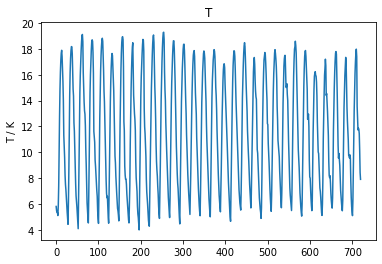

In [12]:
qplt.plot(tempcube[:,0,30,30])

and the same for non-convective rainfall from the rain cubes

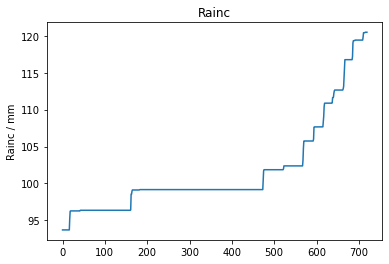

In [16]:
qplt.plot(raincubes[1][:,30,30])

Processing the data
---

We can see here that the time axis isn't showing us dates, just raw numbers. To try and fix that we can examine the tempcube variable

In [11]:
tempcube

<iris 'Cube' of T / (K) (-- : 720; -- : 49; -- : 75; -- : 75)>

Currently, the cube only has auxilary coordinates. Latitude and longitude have not been seperated out into their own dimentions, which we need to do if we want to do any complex plotting or allow iris to understand the metadata. The below function fixes that, so we run it on our temp and rain cubes.

In [17]:
def fix_wrf_coords(cube):
    ''' takes wrf cube and makes proper dimcoords '''
    # all cubes have time coords
    iris.util.promote_aux_coord_to_dim_coord(cube,"XTIME")
    if len(cube.shape) >= 3: # if cube has lat/long coords
        latcoord = iris.coords.DimCoord(cube.coord("latitude")[0,:,0].points,var_name="latitude")
        longcoord = iris.coords.DimCoord(cube.coord("longitude")[0,0,:].points,var_name="longitude")
        cube.remove_coord(cube.coords()[-1])
        cube.remove_coord(cube.coords()[-1])
        if len(cube.shape) == 4: # if there's a variable before lat/long
            cube.add_dim_coord(latcoord,[2])
            cube.add_dim_coord(longcoord,[3])
        else:
            cube.add_dim_coord(latcoord,[1])
            cube.add_dim_coord(longcoord,[2])
    return cube
        
        

In [18]:
varcube = fix_wrf_coords(tempcube)

In [19]:
varcube

<iris 'Cube' of T / (K) (XTIME: 720; -- : 49; latitude: 75; longitude: 75)>

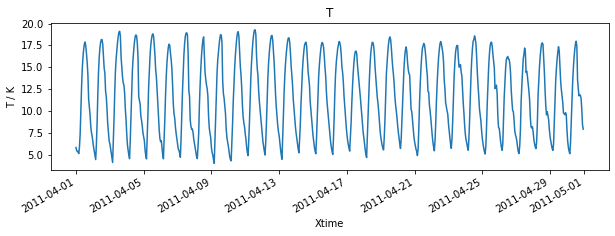

In [38]:
def extended_plot(cube):
    fig = plt.figure(figsize=(10,3))
    if len(cube.shape) == 3:
        qplt.plot(cube[:,30,30])
    elif len(cube.shape) == 4:
        qplt.plot(cube[:,0,30,30])
    fig.autofmt_xdate()
extended_plot(varcube)

Plotting the data
---

So we have a line graph with dates inbuild, but selecting random grid cells is not very useful. How do we make a graph for a area we define with lat/longitude? 

In [44]:
def plot_from_latlong(cube,lats,longs):
    latcon = iris.Constraint(latitude=lambda cell: lats[0] < cell < lats[1])
    longcon = iris.Constraint(longitude=lambda cell: longs[0] < cell < longs[1])
    plotcube = cube.extract(latcon & longcon)
    plotcube = plotcube.collapsed(["latitude","longitude"],iris.analysis.MEAN)
    fig = plt.figure(figsize=(10,3))
    if len(plotcube.shape) == 2:
        qplt.plot(plotcube[:,0])
    elif len(plotcube.shape) == 1:
        qplt.plot(plotcube)
    fig.autofmt_xdate()


Here we've written a function to create "Constraint" objects from latitude/longtide pairs we give it, chop out the that section of the cube, take the mean of all those points, and then do a line plot as above on it. Trying it out, we produce one plot over lake victoria and another over Nairobi

/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/cube.py:3696: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/cube.py:3696: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:

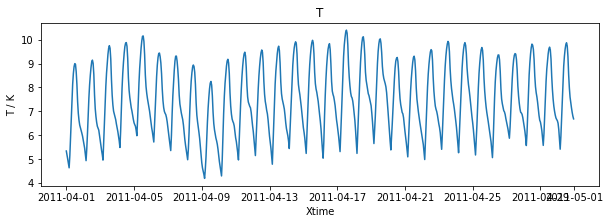

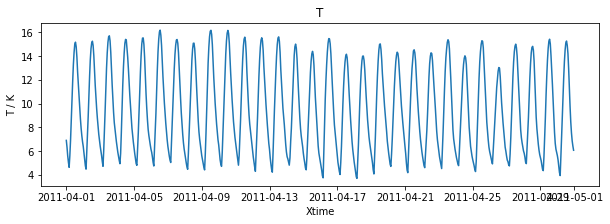

In [46]:
varcube.coords()
plot_from_latlong(varcube,[-2.8,0.5],[31.5,34.4])
plot_from_latlong(varcube,[-1.5,-0.8],[36.4,37.2])

Now we've got some nice line graphs, but how about maps? Iris has several in-build plot mapping commands, depending if your data is best represented as a contour or indervidual grid boxes. Since you can only put 2D information on a map, you must put as input a 2D section of the input time - here it is fixed in height and time to get a 2D slice

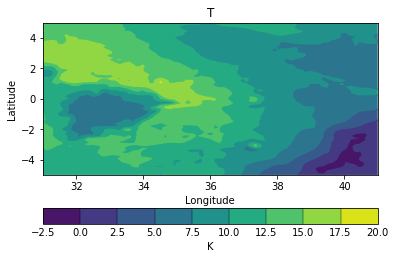

In [49]:
qplt.contourf(varcube[400,0])


/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


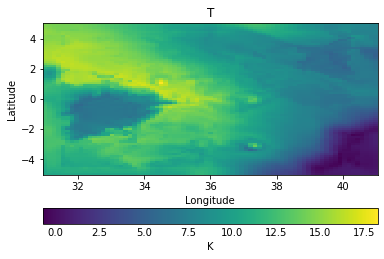

In [ ]:
qplt.pcolormesh(varcube[400,0])


Again, only being able to plot a single time is not very useful. This is where we can combine it with the .collapsed method again to take the mean over the entire time period and map that instead. The mean isn't the only calculation that can be done either - minimums, maximums, standard deviation.. full list in the iris documentation [here](https://scitools-iris.readthedocs.io/en/v3.0.0/generated/api/iris/analysis.html)

/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'XTIME'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


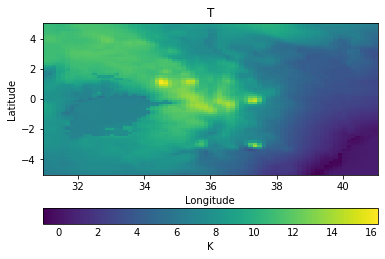

In [57]:
qplt.pcolormesh(varcube.collapsed("XTIME",iris.analysis.MEAN)[0])

/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'XTIME'.
  warnings.warn(msg.format(self.name()))


AttributeError: 'AxesSubplot' object has no attribute 'coastlines'

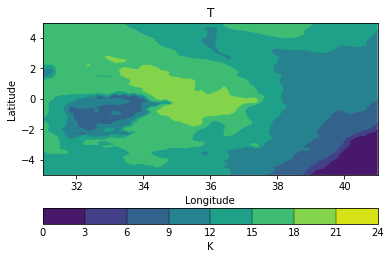

In [62]:
qplt.contourf(varcube.collapsed("XTIME",iris.analysis.MAX)[0])
plt.gca().coastlines()

/opt/scitools/conda/deployments/default-current/lib/python3.8/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'XTIME'.
  warnings.warn(msg.format(self.name()))


AttributeError: module 'iris.quickplot' has no attribute 'gca'

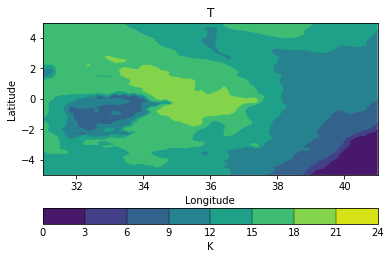

In [64]:
qplt.contourf(varcube.collapsed("XTIME",iris.analysis.MAX)[0])

Combining the above two sections, you should now be able to make maps of smaller areas by the same principle of extracting the subcube from the cube, then plotting it. Why not give it 